In [10]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CMG.csv')
df1=df.reset_index()['Price']

In [12]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [14]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [17]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 97ms/step - loss: 0.0293 - val_loss: 0.0989
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0112
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0.0126
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 8/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0135
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0120
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0113

In [19]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 8ms/step


In [20]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))


In [21]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

# Tính MAE cho Test và Validate
mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

# Tính MAPE cho Test và Validate
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100


print('Validation RMSE:', valid_rmse)
print("Validate MAE: ", mae_val)
print("Validate MAPE: ", mape_val)

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Validation RMSE: 1088.8324709513427
Validate MAE:  1024.6935177364865
Validate MAPE:  2.449628623369907
Testing RMSE: 1991.895784801056
Test MAE:  1555.4053969109195
Test MAPE:  3.2028149812117683


In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[37:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1




0 day input [0.56905504 0.56206566 0.55707325 0.55807173 0.56206566 0.57205048
 0.58403227 0.6219746  0.61198978 0.61398674 0.58403227 0.60000799
 0.61198978 0.60200495 0.57804138 0.59102165 0.59102165 0.58203531
 0.59002316 0.59002316 0.58403227 0.57804138 0.57704289 0.59002316
 0.59002316 0.55208084 0.57005352 0.56306414 0.55008387 0.56406262
 0.57005352 0.56106718 0.53810208 0.56106718 0.55907021 0.56605959
 0.56206566 0.57205048 0.56805655 0.54009905 0.57804138 0.57205048
 0.57404745 0.55807173 0.571052   0.55607477 0.56206566 0.56306414
 0.56106718 0.5600687  0.55208084 0.55108235 0.55008387 0.56406262
 0.56306414 0.59002316 0.58103682 0.58403227 0.58403227 0.58702772
 0.58203531 0.58902468 0.58902468 0.58902468 0.5880262  0.5880262
 0.58503075 0.58503075 0.58203531 0.57804138 0.58003834 0.58203531
 0.58403227 0.58303379 0.58203531 0.58203531 0.58103682 0.58103682
 0.58103682 0.58003834 0.58003834 0.57704289 0.57205048 0.57205048
 0.57005352 0.56805655 0.56206566 0.56705807 0.5660

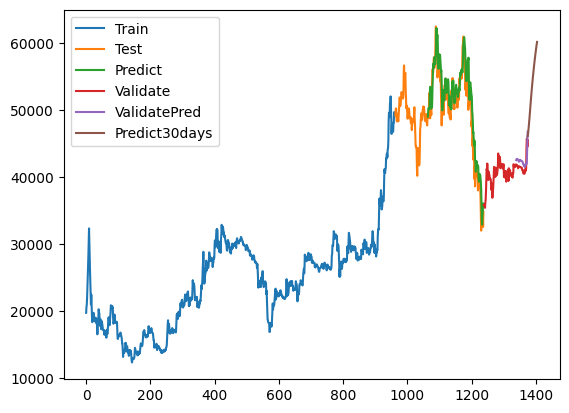

[[46063.29828715]
 [46449.32355094]
 [46923.97237372]
 [47431.0685463 ]
 [47970.68967247]
 [48539.82114244]
 [49131.95915937]
 [49739.11948442]
 [50352.94179869]
 [50965.50155854]
 [51570.02633858]
 [52161.27788115]
 [52735.73416686]
 [53291.5177803 ]
 [53828.14519   ]
 [54346.18947029]
 [54846.86541939]
 [55331.68332696]
 [55802.09677219]
 [56259.30861425]
 [56704.11578465]
 [57136.87943959]
 [57557.58465528]
 [57965.90310788]
 [58361.312464  ]
 [58743.26352739]
 [59111.22202563]
 [59464.80292439]
 [59803.80624461]
 [60128.20512342]]


In [23]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+ 101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size + 101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# kết quả dự đoán 30 ngày
print(scaler.inverse_transform(lst_output))
